In [7]:
import numpy as np
from ast import literal_eval
import matplotlib.pyplot as plt
import pandas as pd
import tqdm
import json

# Data Independent Approach to Dataset Analysis

With new efficient truncation and coefficient computation methods based on marginal approximations, etc can setup new approach to dataset analysis:

- loop over samples and bootstrap, storing CI bounds and OB truncation
- for all OB counts compute and store OG truncation
- for all OB counts use OG truncation to compute and store coefficient grids
- then for any model can use stored info to construct optimization constraints

For now simply use dataset stored as csv file and capture efficiency as numpy array, but will later change functions to work with package dataset objects and store info.

# Example dataset

In [4]:
dataset = pd.read_csv("../Realistic-Data/Sampled-Capture-Data/Datasets/counts_easy_downsampled.csv", index_col=0)
beta = np.loadtxt("../Realistic-Data/Sampled-Capture-Data/Datasets/beta.csv")

# Bootstrap

### Bootstrap function

Takes in a sample and compute CI bounds and OB truncation information

### Bootstrap dataset

Given a dataset, loop over each sample and bootstrap, storing the CI bounds and OB truncations in named files

In [12]:
def bootstrap(sample, resamples=None, splits=1, thresh_OB=10, threshM_OB=10, plot=False, printing=False):
    '''
    Compute confidence intervals on the distribution of a sample of count pairs.

    Compute confidence intervals for the joint and marginal probabilities of the 
    sample using the percentile bootstrap and settings specified in the method
    object. Compute a state space truncation using a given threshold on the
    number of samples per interval, replacing intervals on probabilities of
    states outside the truncation by [0, 1] to improve coverage.

    Args:
        sample: list of tuples (x1, x2) of integer counts per cell
        method: instance of Hypothesis or Minimization class with settings
                stored as attributes

                .resamples: integer number of bootstrap resamples to use
                .splits: integer number of times to 'split' resampling across
                         multiple arrays to avoid memory issues
                .thresh_OB: threshold on observation frequency of a state pair
                            for state space truncation
                .threshM_OB: threshold on observation frequency on a state for
                             marginal state space truncation
        
        plot: toggle plotting of confidence intervals and estimates
        print: toggle printing of observed state space truncation

    Returns:
        A dictionary containing results

        Sample information:

        'sample': original sample used
        'sample_counts': occurances of each state pair in the original sample
        'sample_counts_x1': occurances of each state in the original sample (gene 1)
        'sample_counts_x2': occurances of each state in the original sample (gene 2)

        Confidence intervals:
    
        'joint': (2, _, _) numpy array of CI bounds on joint distribution
        'x1': (2, _) numpy array of CI bounds on marginal distribution (gene 1)
        'x2': (2, _) numpy array of CI bounds on marginal distribution (gene 2)

        Truncation information

        'min_x1_OB', 'max_x1_OB', 'min_x2_OB', 'max_x2_OB': joint truncation
        'minM_x1_OB', 'maxM_x1_OB': marginal truncation (gene 1)
        'minM_x2_OB', 'maxM_x2_OB': marginal truncation (gene 2)
        'thresh_flag': bool if joint state space was truncated
        'thresh_flag_x1': bool if marginal state space was truncated (gene 1)
        'thresh_flag_x2': bool if marginal state space was truncated (gene 2)
    '''

    # get sample size
    n = len(sample)

    # get bootstrap size: default to sample size
    if resamples is None:
        resamples = n

    # initialize random generator
    rng = np.random.default_rng()

    # convert string to tuple if neccessary (pandas reading csv to string)
    if type(sample[0]) == str:
        sample = [literal_eval(count_pair) for count_pair in sample]

    # compute maximum x1 and x2 values
    M, N = np.max(sample, axis=0)
    M, N = int(M), int(N)

    # map (x1, x2) pairs to integers: x2 + (N + 1) * x1
    integer_sample = np.array([x[1] + (N + 1)*x[0] for x in sample], dtype='uint32')

    # maxiumum of integer sample
    D = (M + 1)*(N + 1) - 1

    # number of bootstrap samples per split (split to reduce memory usage)
    resamples_split = resamples // splits

    # setup count array
    counts = np.empty((resamples, M + 1, N + 1), dtype='uint32')

    # BS bootstrap samples: split into 'splits' number of BS_split x n arrays
    for split in range(splits):

        # BS_split bootstrap samples as BS_split x n array
        bootstrap_split = rng.choice(integer_sample, size=(resamples_split, n))

        # offset row i by (D + 1)i
        bootstrap_split += np.arange(resamples_split, dtype='uint32')[:, None]*(D + 1)

        # flatten, count occurances of each state and reshape, reversing map to give counts of each (x1, x2) pair
        counts_split = np.bincount(bootstrap_split.ravel(), minlength=resamples_split*(D + 1)).reshape(-1, M + 1, N + 1)

        # add to counts
        counts[(split * resamples_split):((split + 1) * resamples_split), :, :] = counts_split

    # sum over columns / rows to give counts (/n) of each x1 / x2 state
    x1_counts = counts.sum(axis=2)
    x2_counts = counts.sum(axis=1)

    # compute 2.5% and 97.5% quantiles for each p(x1, x2), p(x1) and p(x2)
    bounds = np.quantile(counts, [0.025, 0.975], axis=0)
    x1_bounds = np.quantile(x1_counts, [0.025, 0.975], axis=0)
    x2_bounds = np.quantile(x2_counts, [0.025, 0.975], axis=0)

    # scale to probability
    bounds = bounds / n
    x1_bounds = x1_bounds / n
    x2_bounds = x2_bounds / n

    # count occurances per (x1, x2) in the in original sample
    sample_counts = np.bincount(integer_sample, minlength=D + 1).reshape(M + 1, N + 1)

    # sum over columns / rows to give counts per x1 / x2 state
    x1_sample_counts = sample_counts.sum(axis=1)
    x2_sample_counts = sample_counts.sum(axis=0)

    # set truncation bounds
    min_x1_OB, max_x1_OB, min_x2_OB, max_x2_OB = M, 0, N, 0
    minM_x1_OB, maxM_x1_OB = M, 0
    minM_x2_OB, maxM_x2_OB = N, 0

    # set flag for changes
    thresh_flag = False
    thresh_flag_x1 = False
    thresh_flag_x2 = False

    # replace CI's for states below threshold occurances by [0, 1] bounds
    for x1 in range(M + 1):
        for x2 in range(N + 1):
            # below: replace
            if sample_counts[x1, x2] < thresh_OB:
                bounds[:, x1, x2] = [0.0, 1.0]
            # above: update truncation
            else:
                # check if smaller than current min
                if x1 < min_x1_OB:
                    min_x1_OB = x1
                    thresh_flag = True
                if x2 < min_x2_OB:
                    min_x2_OB = x2
                    thresh_flag = True
                # check if larger than current max
                if x1 > max_x1_OB:
                    max_x1_OB = x1
                    thresh_flag = True
                if x2 > max_x2_OB:
                    max_x2_OB = x2
                    thresh_flag = True

    for x1 in range(M + 1):
        # below: replace
        if x1_sample_counts[x1] < threshM_OB:
            x1_bounds[:, x1] = [0.0, 1.0]
        # above: update truncation
        else:
            # check if smaller than current min
            if x1 < minM_x1_OB:
                minM_x1_OB = x1
                thresh_flag_x1 = True
            # check if larger than current max
            if x1 > maxM_x1_OB:
                maxM_x1_OB = x1
                thresh_flag_x1 = True

    for x2 in range(N + 1):
        # below: replace
        if x2_sample_counts[x2] < threshM_OB:
            x2_bounds[:, x2] = [0.0, 1.0]
        # above: update truncation
        else:
            # check if smaller than current min
            if x2 < minM_x2_OB:
                minM_x2_OB = x2
                thresh_flag_x2 = True
            # check if larger than current max
            if x2 > maxM_x2_OB:
                maxM_x2_OB = x2
                thresh_flag_x2 = True

    # if no states were above threshold: default to max range, report
    if not thresh_flag:
        min_x1_OB, max_x1_OB, min_x2_OB, max_x2_OB = 0, M, 0, N
    if not thresh_flag_x1:
        minM_x1_OB, maxM_x1_OB = 0, M
    if not thresh_flag_x2:
        minM_x2_OB, maxM_x2_OB = 0, N

    # plotting
    if plot:
        fig, axs = plt.subplots(M + 1, N + 1, figsize=(10, 10))
        fig.tight_layout()
        for x1 in range(M + 1):
            for x2 in range(N + 1):
                # within truncation: green CI lines
                if (x1 >= min_x1_OB) and (x2 >= min_x2_OB) and (x1 <= max_x1_OB) and (x2 <= max_x2_OB):
                    color = "green"
                else:
                    color = "red"
                axs[x1, x2].hist(counts[:, x1, x2] / n)
                axs[x1, x2].set_title(f"p({x1}, {x2})")
                axs[x1, x2].axvline(bounds[0, x1, x2], color=color)
                axs[x1, x2].axvline(bounds[1, x1, x2], color=color)

        plt.suptitle("X1 X2 Confidence Intervals")
        plt.show()

        fig, axs = plt.subplots(1, M + 1, figsize=(10, 3))
        fig.tight_layout()
        for x1 in range(M + 1):
            # within truncation: green CI lines
            if (x1 >= minM_x1_OB) and (x1 <= maxM_x1_OB):
                color = "green"
            else:
                color = "red"
            axs[x1].hist(x1_counts[:, x1] / n)
            axs[x1].set_title(f"p({x1})")
            axs[x1].axvline(x1_bounds[0, x1], color=color)
            axs[x1].axvline(x1_bounds[1, x1], color=color)

        plt.suptitle("X1 Confidence Intervals")
        plt.show()

        fig, axs = plt.subplots(1, N + 1, figsize=(10, 3))
        fig.tight_layout()
        for x2 in range(N + 1):
            # within truncation: green CI lines
            if (x2 >= minM_x2_OB) and (x2 <= maxM_x2_OB):
                color = "green"
            else:
                color = "red"
            axs[x2].hist(x2_counts[:, x2] / n)
            axs[x2].set_title(f"p({x2})")
            axs[x2].axvline(x2_bounds[0, x2], color=color)
            axs[x2].axvline(x2_bounds[1, x2], color=color)

        plt.suptitle("X2 Confidence Intervals")
        plt.show()

    # printing
    if printing:
        print(f"Box truncation: [{min_x1_OB}, {max_x1_OB}] x [{min_x2_OB}, {max_x2_OB}]")
        print(f"Marginal x1 truncation: [{minM_x1_OB}, {maxM_x1_OB}]")
        print(f"Marginal x2 truncation: [{minM_x2_OB}, {maxM_x2_OB}]")

    # collect results
    truncation_OB = {
        'min_x1_OB': min_x1_OB,
        'max_x1_OB': max_x1_OB,
        'min_x2_OB': min_x2_OB,
        'max_x2_OB': max_x2_OB
    }

    result_dict = {
        'bounds': bounds,
        'truncation_OB': truncation_OB
    }

    # for now ignore marginal bounds
    '''
    bounds_dict =  {
        'sample': sample,
        'sample_counts': sample_counts,
        'sample_counts_x1': x1_sample_counts,
        'sample_counts_x2': x2_sample_counts,
        'joint': bounds,
        'x1': x1_bounds,
        'x2': x2_bounds,
        'min_x1_OB': min_x1_OB,
        'max_x1_OB': max_x1_OB,
        'min_x2_OB': min_x2_OB,
        'max_x2_OB': max_x2_OB,
        'minM_x1_OB': minM_x1_OB,
        'maxM_x1_OB': maxM_x1_OB,
        'minM_x2_OB': minM_x2_OB,
        'maxM_x2_OB': maxM_x2_OB,
        'thresh_flag': thresh_flag,
        'thresh_flag_x1': thresh_flag_x1,
        'thresh_flag_x2': thresh_flag_x2
    }
    '''

    return result_dict

In [18]:
def bootstrap_dataset(dataset):

    # size
    gene_pairs, cells = dataset.shape

    # collect OB truncations
    truncation_dict = {}

    # loop over samples
    for i in tqdm.tqdm(range(gene_pairs)):

        # select sample
        sample = list(dataset.loc[f'Gene-pair-{i}'])

        # bootstrap
        result_dict = bootstrap(sample)

        # store OB truncation
        truncation_dict[f'sample-{i}'] = result_dict['truncation_OB']

        # save CI bounds
        np.save(
            f"./Test-Info/Bounds/sample-{i}.npy",
            result_dict['bounds']
        )

    # save OB truncations
    json.dump(
        truncation_dict,
        open(f"./Test-Info/Truncation-OB/truncation_OB.json", 'w')
    )

## Testing

In [19]:
bootstrap_dataset(dataset)

100%|██████████| 200/200 [00:10<00:00, 18.57it/s]


In [70]:
def illustrate_truncation():
    rng = np.random.default_rng()
    fig, axs = plt.subplots(figsize=(6, 6))
    truncation_dict = json.load(open("./Test-Info/Truncation-OB/truncation_OB.json"))
    for i, truncation in truncation_dict.items():
        colour = list(rng.integers(0, 256, size=3))
        axs.hlines([truncation['min_x1_OB'] - 0.5, truncation['max_x1_OB'] + 0.5], xmin=truncation['min_x2_OB'] - 0.5, xmax=truncation['max_x2_OB'] + 0.5, color=[colour, colour], linewidth=2)
        axs.vlines([truncation['min_x2_OB'] - 0.5, truncation['max_x2_OB'] + 0.5], ymin=truncation['min_x1_OB'] - 0.5, ymax=truncation['max_x1_OB'] + 0.5, color=[colour, colour], linewidth=2)

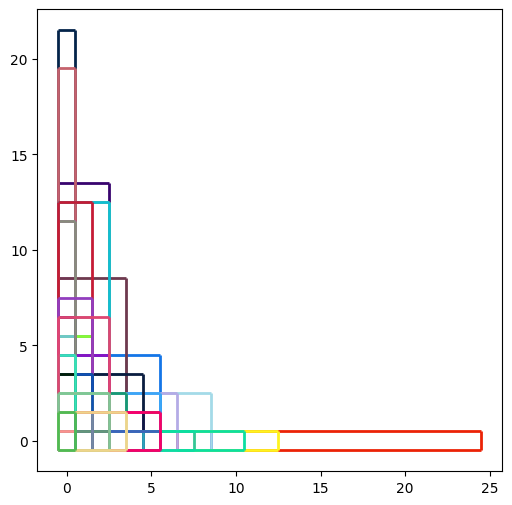

In [72]:
illustrate_truncation()

# Original Truncation

For every pair of observed counts $(x_{1}^{OB}, x_{2}^{OB})$ in the observed truncations of samples (computed during the bootstrap) need to compute and store the original truncation bounds for use in constraints

In [81]:
def truncation_summary(filename):
    '''
    Find all OB state pairs included within a collection of truncations and the
    minimum and maximum single state value

    Returns set of state pairs and min and max state values
    '''

    # load truncations
    truncation_dict = json.load(open(filename))

    # state set
    states = set()

    # min and max states
    min_state, max_state = np.inf, 0

    # loop over each truncation
    for i, trunc in truncation_dict.items():

        # update min and max states
        if trunc['min_x1_OB'] < min_state:
            min_state = trunc['min_x1_OB']
        if trunc['min_x2_OB'] < min_state:
            min_state = trunc['min_x2_OB']
        if trunc['max_x1_OB'] > max_state:
            max_state = trunc['max_x1_OB']
        if trunc['max_x2_OB'] > max_state:
            max_state = trunc['max_x2_OB']

        # for each state pair in truncation
        for x1_OB in range(trunc['min_x1_OB'], trunc['max_x1_OB'] + 1):
            for x2_OB in range(trunc['min_x2_OB'], trunc['max_x2_OB'] + 1):

                # add to set
                states.add((x1_OB, x2_OB))

    # collect info
    truncation_info = {
        'states': states,
        'min_state': min_state,
        'max_state': max_state
    }

    return truncation_info

In [ ]:
def compute_original_truncation()

In [82]:
truncation_info = truncation_summary("./Test-Info/Truncation-OB/truncation_OB.json")